In [182]:
import pandas as pd
import re
import numpy as np
import itertools
import collections
from collections import defaultdict, Counter
import string

import nltk
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

import gensim
from gensim.models import KeyedVectors, Word2Vec, FastText
import tensorflow as tf


[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\I.V.SRICHANDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I.V.SRICHANDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\I.V.SRICHANDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\I.V.SRICHANDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\I.V.SRICHANDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [183]:

# Preprocess data function
def preprocess_data(text):
    user_name = '@[A-Za-z0-9]+'  # Pattern for matching the user names in the tweet
    has_tag = '#[A-Za-z0-9]+'  # Pattern for matching the hashtags in the tweet
    url = 'https?:\/\/[A-Za-z0-9\.\/\-]+'  # Pattern for matching the URLs in the tweet

    x = text.lower()  # Lower casing all the characters
    x = re.sub(user_name, '', x)  # Replace the username with an empty character
    x = re.sub(has_tag, '', x)  # Replace the hashtags with an empty character
    x = re.sub(url, '', x)  # Replace the URLs with an empty character
    x = x.translate(str.maketrans('', '', string.punctuation))  # Replace all the characters except alphabets and digits from the tweet

    return x


In [184]:
import pandas as pd
import re
import string
import tensorflow as tf
import numpy as np
import itertools

# Load training data
train_df = pd.read_csv("Tulu_SA_train.csv")
train_df.head()

# Load validation data
valid_df = pd.read_csv("Tulu_SA_val.csv")
valid_df.head()

# Load test data without labels
test_df = pd.read_csv("Tulu_SA_test_without_label.csv")


train_df["Text"] = train_df["Text"].apply(lambda x: preprocess_data(x))
valid_df["Text"] = valid_df["Text"].apply(lambda x: preprocess_data(x))
test_df["Text"] = test_df["Text"].apply(lambda x: preprocess_data(x))

In [185]:
train_label = train_df["Label"].tolist()
valid_label = valid_df["Label"].tolist()


In [186]:
class_names = list(set(train_label))
class_names

['Neutral', 'Positive', 'Mixed', 'Not Tulu', 'Negative', nan]

In [187]:
class_names = list(set(valid_label))
class_names

['Neutral', 'Positive', 'Mixed', 'Not Tulu', 'Negative', nan]

In [188]:
# seeing the rows of column "Label" is nan
train_df[train_df["Label"].isna()]

# removing the rows of column "Label" is nan
train_df = train_df.dropna(subset=["Label"])
train_df = train_df.reset_index(drop=True)

# removing the rows of column "Label" is nan in validation data
valid_df = valid_df.dropna(subset=["Label"])
valid_df = valid_df.reset_index(drop=True)

# checking the rows of column "Label" is nan
train_df[train_df["Label"].isna()]

# removing the label "nan" from the list
train_label = train_df["Label"].tolist()
valid_label = valid_df["Label"].tolist()



In [189]:
class_dist = Counter(train_label)
class_dist

Counter({'Not Tulu': 4400,
         'Positive': 3769,
         'Neutral': 3175,
         'Mixed': 1114,
         'Negative': 843})

In [190]:
le = LabelEncoder()

train_label = le.fit_transform(train_label)
valid_label = le.fit_transform(valid_label)

In [191]:
le.inverse_transform([0,1,2,3,4])

array(['Mixed', 'Negative', 'Neutral', 'Not Tulu', 'Positive'],
      dtype='<U8')

In [192]:
class_weight = {0:sum(class_dist.values())/class_dist[le.inverse_transform([0])[0]],
                1:sum(class_dist.values())/class_dist[le.inverse_transform([1])[0]],
                2:sum(class_dist.values())/class_dist[le.inverse_transform([2])[0]],
                3:sum(class_dist.values())/class_dist[le.inverse_transform([3])[0]],
                4:sum(class_dist.values())/class_dist[le.inverse_transform([4])[0]],
                }

class_weight

{0: 11.939856373429084,
 1: 15.778173190984578,
 2: 4.189291338582677,
 3: 3.0229545454545454,
 4: 3.5290527991509686}

In [193]:
training_labels = tf.keras.utils.to_categorical(train_label)
validation_labels = tf.keras.utils.to_categorical(valid_label)

In [194]:
!pip install WordCloud

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: pytorch-lightning 1.5.10 has a non-standard dependency specifier torch>=1.7.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [195]:
words_in_train = [sent.split() for sent in train_df["Text"]]
words_in_train[0:5]

[['aunty', 'log', 'bohot', 'kadak', 'hai'],
 ['shruthi',
  'was',
  'awesome',
  'nice',
  'collaboration',
  'hope',
  'we',
  'see',
  'her',
  'in',
  'ur',
  'upcoming',
  'vlogs',
  '😊'],
 ['gol', 'gappadh', 'ammana', 'sajjigene', 'best'],
 ['chaddida', 'brand', 'thojodijji', 'marre😃😃😃'],
 ['memories', 'just', 'got', 'refreshed']]

In [196]:
words_in_valid = [sent.split() for sent in valid_df["Text"] ]
words_in_valid[0:5]

[['boojana', 'spr', 'sathishane', 'spr'],
 ['very', 'super'],
 ['very', 'nice', 'i', 'enjoyed', 'a', 'lot', 'thanks', 'a', 'lot'],
 ['142', 'out', 'standing', 'ಕುಟ್ಟಿ', 'ದೊಣ್ಣೆ'],
 ['telpuna', 'effect', 'bodchi']]

In [197]:
words_in_test = [sent.split() for sent in test_df['Text']] 
words_in_test[0:5]

[['keep', 'it', 'up', 'bro', 'always', 'pukuli🤣🤣🤣'],
 ['nxt', 'comedy', 'film', 'geppanaga', 'umben', 'seravarle', 'iyavu', '😂😂😂'],
 ['how',
  'nepal',
  'is',
  'connected',
  'with',
  'mangalore',
  'music',
  'has',
  'no',
  'barriers',
  '🤣'],
 ['papa', 'mare', 'imbena', 'maya', 'athna', 'pukulin', 'vapas', 'korad'],
 ['ತುಲು',
  'ಪುರ್ಪಗ್',
  'ಬತ್ತ್ಂಡ್',
  'ಅಸ್ಸಾಂ\u200cದ',
  'ಮುಖ್ಯಮಂತ್ರಿಲೆನ',
  'ಉತ್ತರ',
  'sir']]

In [198]:
all_words_train = list(itertools.chain(*words_in_train)) 
all_words_train[0:10]

['aunty',
 'log',
 'bohot',
 'kadak',
 'hai',
 'shruthi',
 'was',
 'awesome',
 'nice',
 'collaboration']

In [199]:
all_words_valid = list(itertools.chain(*words_in_valid)) 
all_words_valid[0:10]

['boojana',
 'spr',
 'sathishane',
 'spr',
 'very',
 'super',
 'very',
 'nice',
 'i',
 'enjoyed']

In [200]:
all_words_test = list(itertools.chain(*words_in_test)) 
all_words_test[0:10]

['keep',
 'it',
 'up',
 'bro',
 'always',
 'pukuli🤣🤣🤣',
 'nxt',
 'comedy',
 'film',
 'geppanaga']

In [201]:
word_counts_train = collections.Counter(all_words_train)  
word_counts_train.most_common(15)

[('super', 1117),
 ('comedy', 652),
 ('pukuli', 597),
 ('the', 584),
 ('song', 488),
 ('undu', 464),
 ('is', 451),
 ('tulu', 437),
 ('i', 426),
 ('da', 403),
 ('bro', 395),
 ('and', 393),
 ('sir', 383),
 ('movie', 380),
 ('anna', 347)]

In [202]:
word_counts_valid = collections.Counter(all_words_valid)  
word_counts_valid.most_common(15)

[('super', 126),
 ('the', 82),
 ('pukuli', 77),
 ('comedy', 67),
 ('and', 66),
 ('song', 61),
 ('tulu', 58),
 ('undu', 56),
 ('anna', 53),
 ('is', 52),
 ('sir', 50),
 ('of', 49),
 ('bro', 49),
 ('da', 49),
 ('i', 48)]

In [203]:
word_counts_test = collections.Counter(all_words_test)  
word_counts_test.most_common(15)

[('super', 125),
 ('comedy', 96),
 ('pukuli', 65),
 ('song', 60),
 ('the', 54),
 ('tulu', 53),
 ('undu', 53),
 ('sir', 49),
 ('i', 49),
 ('is', 48),
 ('da', 47),
 ('best', 45),
 ('and', 44),
 ('movie', 41),
 ('bro', 38)]

In [204]:
words_with_counts_train = pd.DataFrame(word_counts_train.most_common(len(all_words_train)), columns=['words', 'count']) 
print(words_with_counts_train.head())

    words  count
0   super   1117
1  comedy    652
2  pukuli    597
3     the    584
4    song    488


In [205]:
words_with_counts_valid = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

    words  count
0   super    126
1     the     82
2  pukuli     77
3  comedy     67
4     and     66


In [206]:
words_with_counts_test = pd.DataFrame(word_counts_test.most_common(len(all_words_test)), columns=['words', 'count']) 
print(words_with_counts_test.head())

    words  count
0   super    125
1  comedy     96
2  pukuli     65
3    song     60
4     the     54


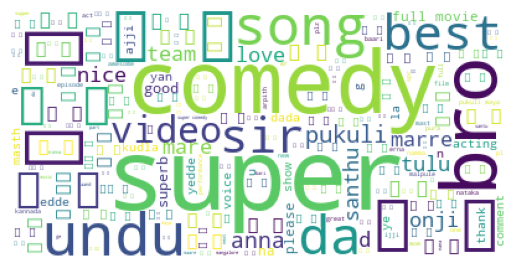

In [207]:
text = " ".join(all_words_train)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

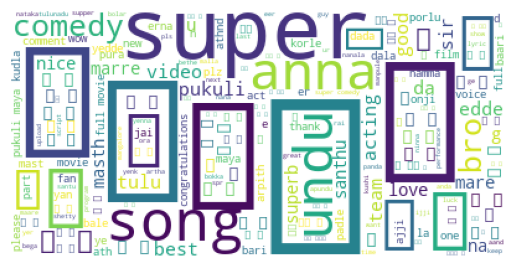

In [208]:
text = " ".join(all_words_valid)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

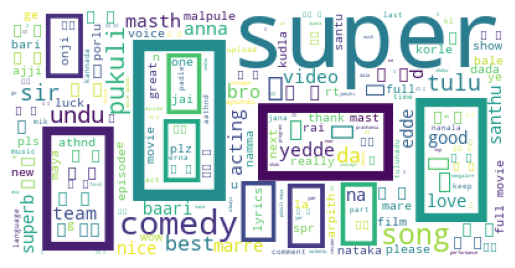

In [209]:
text = " ".join(all_words_test)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [210]:
train_text = train_df['Text'].tolist()
valid_text = valid_df['Text'].tolist()
test_text = test_df['Text'].tolist()

train_label = train_df['Label'].tolist()
valid_label = valid_df['Label'].tolist()

In [211]:
all_words = all_words_train + all_words_valid 
corpus = train_text + valid_text
vocab_size = len(set(all_words)) 
embedding_dim = 100 
max_length = 0
for i in range(len(corpus)):
  x = word_tokenize(corpus[i])
  if len(x) > max_length:
    max_length = len(x)

oov_tok = "<OOV>" 

In [212]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [213]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences,maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(valid_text)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,maxlen=max_length, padding='post')

train_padded = np.concatenate((training_padded, valid_padded), axis=0)

test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length, padding='post')


In [214]:
METRICS = [

      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
filter_size = 128
kernel_size = 5
pool_size = 5
n_classes=len(class_names)
print(n_classes)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(max_length,)),
    tf.keras.layers.Conv1D(filter_size, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size, padding='same'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_classes-1, activation=tf.nn.softmax)
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=METRICS
)

model.summary()


6


C:\Users\I.V.SRICHANDRA\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 40, 100)        │     2,713,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 40, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,820,889 (10.76 MB)

 Trainable params: 2,820,889 (10.76 MB)

 Non-trainable params: 0 (0.00 B)

In [237]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

num_epochs = 100
history = model.fit(
    training_padded, 
    training_labels,
    epochs=num_epochs,
    validation_data=(valid_padded, validation_labels),
    verbose=2,
    callbacks=[callback],
    class_weight=class_weight
)




Epoch 1/100
416/416 - 16s - 40ms/step - accuracy: 0.8770 - auc: 0.8900 - loss: 5.0785 - precision: 0.7451 - recall: 0.5851 - val_accuracy: 0.8224 - val_auc: 0.7619 - val_loss: 1.3546 - val_precision: 0.5983 - val_recall: 0.3410
Epoch 2/100
416/416 - 16s - 37ms/step - accuracy: 0.8593 - auc: 0.8575 - loss: 5.6173 - precision: 0.7345 - recall: 0.4643 - val_accuracy: 0.8395 - val_auc: 0.7643 - val_loss: 1.3437 - val_precision: 0.6866 - val_recall: 0.3630
Epoch 3/100
416/416 - 15s - 37ms/step - accuracy: 0.8744 - auc: 0.8817 - loss: 5.2313 - precision: 0.7439 - recall: 0.5669 - val_accuracy: 0.8261 - val_auc: 0.7890 - val_loss: 1.3255 - val_precision: 0.5768 - val_recall: 0.4896
Epoch 4/100
416/416 - 17s - 41ms/step - accuracy: 0.8803 - auc: 0.8969 - loss: 4.9545 - precision: 0.7463 - recall: 0.6080 - val_accuracy: 0.8225 - val_auc: 0.7861 - val_loss: 1.3633 - val_precision: 0.5706 - val_recall: 0.4555
Epoch 5/100
416/416 - 16s - 38ms/step - accuracy: 0.8738 - auc: 0.8911 - loss: 5.0154 - 

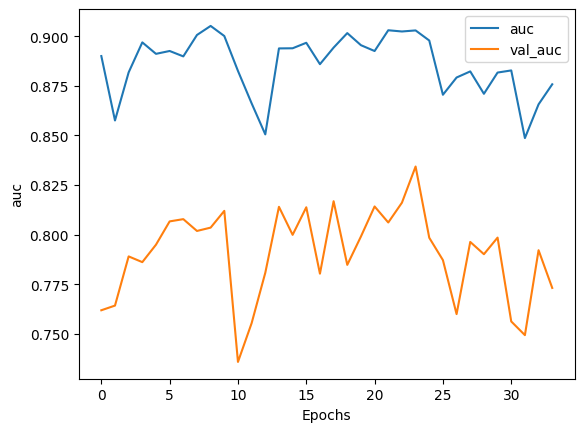

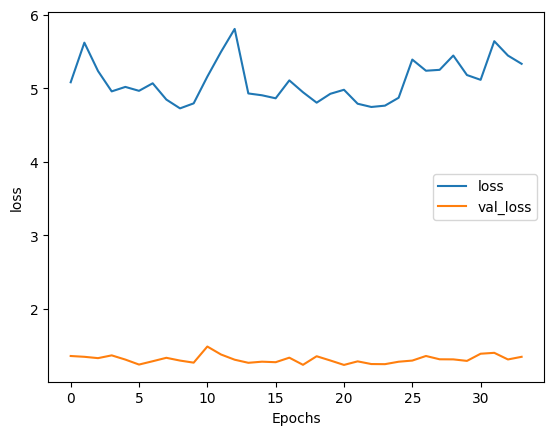

In [238]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "auc")
plot_graphs(history, "loss")


In [239]:
score = model.evaluate(valid_padded, validation_labels)
print("Loss = {}".format(score[0]))
print("Accuracy = {0:.2f}%".format(score[1]*100))


from sklearn.metrics import classification_report
y_pred = model.predict(valid_padded)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(validation_labels, axis=1)

# precision, recall, f1-score, support
pr=precision_score(y_true, y_pred, average='macro')
rc=recall_score(y_true, y_pred, average='macro')
f1=f1_score(y_true, y_pred, average='macro')
print("Precision: ", pr)
print("Recall: ", rc)
print("F1-Score: ", f1)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8431 - auc: 0.8372 - loss: 1.2385 - precision: 0.6328 - recall: 0.5142
Loss = 1.2436822652816772
Accuracy = 84.53%
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Precision:  0.47889843068707594
Recall:  0.4813995572312987
F1-Score:  0.47829333887577574


In [115]:
# model.save('model_tulu.h5') 

In [241]:
# predict the labels on test dataset

predictions = model.predict(test_padded)
predictions = np.argmax(predictions, axis = 1)
predictions = le.inverse_transform(predictions)
# saving the predictions to a csv file
test_df["Label"] = predictions
test_df.to_csv("tulu_test_labels_3.csv", index=False)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
